In [1]:
include("../Inversion/Plot.jl")
include("Lorenz63.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

# Lorenz63 System : Optimization Approach
Consider the famous Lorenz63 system

\begin{equation*}
\begin{split}
    &\frac{dx_1}{dt} = \sigma (x_2 - x_1), \\
    &\frac{dx_2}{dt} = x_1(r-x_3)-x_2,        \\
    &\frac{dx_3}{dt} = x_1x_2-\beta x_3;   \\
\end{split}
\end{equation*}

The system is parameterized by $\sigma, r, \beta \in \mathcal{R}^{+}$. For the usual values
$\sigma = 10, \beta=\frac{8}{3}$, we have 
* When $r < 24.74$, the system is not chaotic, the trajectory converges to one attractor 
* When $24.74 < r < 148.4$, the chaotic motion (strange attractor) appears
* When $148.4 < r < 166.07$, the limit cycle begins
* When $166.07 < r$, the system transits to strange attractor from limit cyle (intermmittency)[1].


1. Manneville, Paul, and Pomeau, Yves. "Intermittency and the Lorenz model." 



## 1-parameter learning

Consider the following one-parameter inverse problem with fixed $\sigma=10$ and $\beta=8/3$:
$$
\begin{equation}
    y = \mathcal{G}(r) + \eta \quad \mathrm{with} \quad y= \overline{x_3} = \frac{1}{20}\int_{30}^{50} f\bigl(x_3(t)\bigr) dt.
\end{equation}
$$

The truth obervation is computed with paremters $\sigma=10$, $r = 28$, and $\beta=8/3$, over a time window of size $T = 200$, also with an initial spin-up period $T = 30$:
$$
\begin{equation}
    y_{truth} =  \frac{1}{200}\int_{30}^{230} f\bigl(x_3(t)\bigr) dt.
\end{equation}
$$
Since the data is generated on an interval 10 times as long as the observation window, we may appeal to the central limit theorem to compute the observation error:
$$
y_{truth} = \frac{1}{10}\sum_{i=1}^{10} y_i \qquad \Sigma_{\eta} = \frac{1}{10}\sum_{i=1}^{9} (y_{truth} - y_i)\cdot (y_{truth} - y_i)^{T}
$$
where 
$$
\begin{equation}
    y_{i} =  \frac{1}{20}\int_{30 + 20(i-1)}^{30 + 20i} f\bigl(x_3(t)\bigr) dt \qquad i=1,\,2,\,\cdots,\,10
\end{equation}
$$


The UKI is initialized with $\theta_0 \sim \mathcal{N}(5.0 \cdot \vec{1}, I)$.


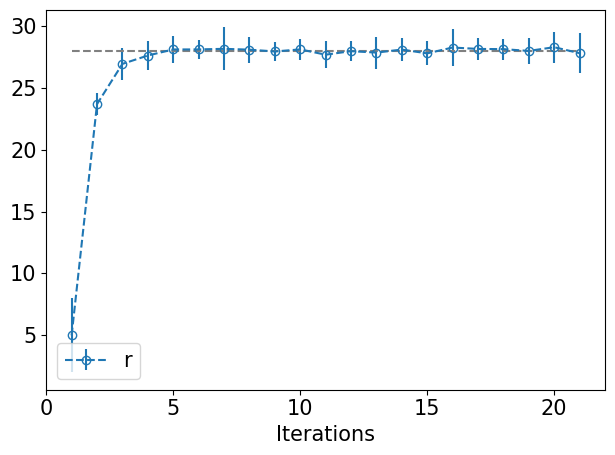

┌ Info: Initialize the 1-parameter Lorenz63 inverse problem
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Chaotic/Lorenz63.jl:210
┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/huang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
┌ Info: At the 20, r=[27.803398987588913], σᵣ=0.5432275054080071
└ @ Main In[2]:24


In [2]:
Tobs = 20.0
Tspinup = 30.0

Δt = 0.01
N_θ = 1
x0 = [-8.67139571762; 4.98065219709; 25]
θ_ref = [10.0 ;28.0;8.0/3.0]

lorenz63_param = Setup_Param(N_θ, Tobs, Tspinup, Δt, x0, θ_ref)

T = Tspinup + 10.0*Tobs
y, Σ_η = data_gen(T, Tobs, Tspinup, f_mean_x3, Δt, θ_ref)

θ0_mean = fill(5.0, N_θ) 
θθ0_cov = Array(Diagonal(fill(1.0^2.0, N_θ)))
N_iter = 20
α_reg = 1.0
update_freq = 0
γ = 2.0
ukiobj = UKI_Run(lorenz63_param, forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, y, Σ_η, γ,  α_reg, update_freq, N_iter)
θ_ref, θ_ref_nemas  = [θ_ref[2]], ["r"]
plot_param_iter(ukiobj, θ_ref, θ_ref_nemas)

@info "At the $(N_iter), r=$(ukiobj.θ_mean[end]), σᵣ=$(sqrt(ukiobj.θθ_cov[end][1,1]))"

The landscape of $\mathcal{G}$ and sensitivity of $\mathcal{G}(\cdot)$ with respect to the input for
observations, derived from such chaotic problems, are widely studied. 
The highly oscillatory landscape and the "blown-up" gradient are reported in [Chaos and butterfly effects](Chaotic/Chaos.ipynb).
That illustrates the challenges inherent in parameter estimation and sensitivity analyses
for chaotic systems. In particular, the ExKI method suffers from the large derivatives
of $\mathcal{G}$.

However, the UKI successfully recovers the parameter $r$, thanks to the averaging property of the UKI. 
The estimation of $r$ at the 20th iteration is $r = 27.8$ and $\sigma_{r} = 0.54$. Based on [1](https://arxiv.org/pdf/2102.01580.pdf),
the landscape of the averaged function $\mathcal{F}\mathcal{G}$ and its associated gradient $\mathcal{F} d\mathcal{G}$, with the standard deviation $\sigma_r = 0.54$ fixed; this
gives an indication of the energy landscape as perceived by the UKI. In particular we have:
\begin{equation*}
\begin{split}
    \mathcal{F}\mathcal{G}(r) = \int \mathcal{G}(x) \frac{1}{\sqrt{2\pi}\sigma_r}e^{-\frac{(x -r)^2}{2\sigma_r^2}} dx, \qquad
    \mathcal{F} d\mathcal{G}(r) = \frac{\int (x-r)(\mathcal{G}(x) - \mathcal{G}(r)) \frac{1}{\sqrt{2\pi}\sigma_r}e^{-\frac{(x -r)^2}{2\sigma_r^2}} dx}{\int(x-r)^2 \frac{1}{\sqrt{2\pi}\sigma_r}e^{-\frac{(x -r)^2}{2\sigma_r^2}} dx}.
\end{split}
\end{equation*}
These functions are depicted. We see that $\mathcal{F}\mathcal{G}$ is smooth (except the transition point), and $\mathcal{F} d\mathcal{G}$ does not suffer from blow-up in the way $d\mathcal{G}$ does;
furthermore $\mathcal{F} d\mathcal{G}$ represents the true gradient $\displaystyle \frac{d\mathcal{G}}{dr} \approx 0.96$ well. This explains why the adjoint/gradient-based methods, including ExKI, fail, but the UKI succeeds for this chaotic inverse problem.


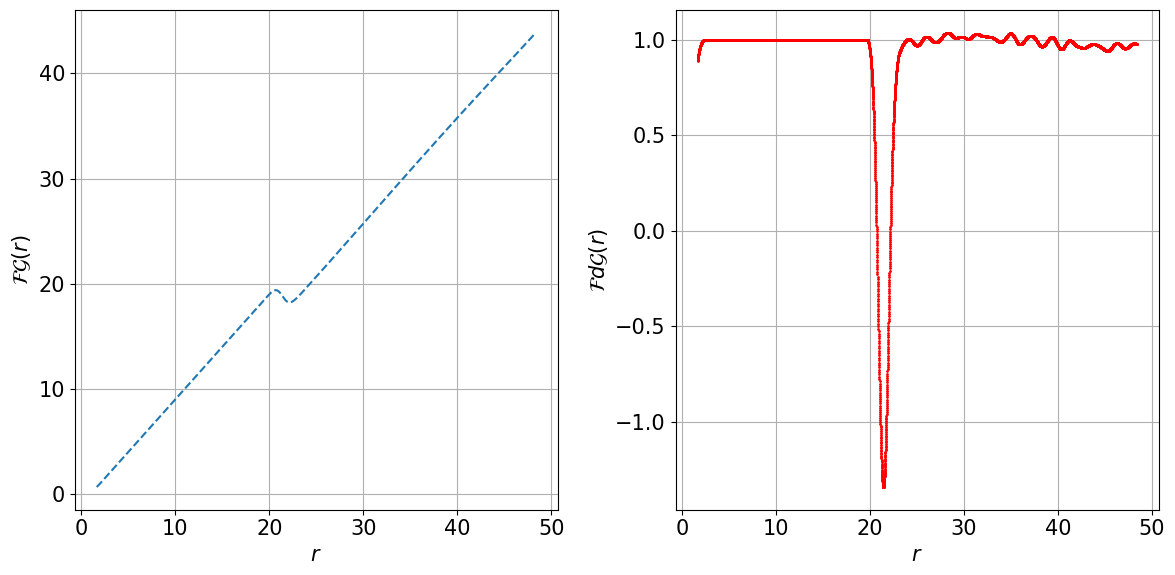

In [3]:
rs = Array(LinRange(0, 50, 10001))
rs, mean_x3s, dmean_x3_drs = compute_dx3_dr_adjoint(rs)
σr = 0.5432275054080071
adjoint_plot(rs, mean_x3s, dmean_x3_drs, σr)

## 3-parameter learning
Consider the following 3-parameter inverse problem
\begin{equation}
    y = \mathcal{G}(\theta)+\eta \quad \mathrm{with} \quad y= (\overline{x_1}, \overline{x_2},\overline{x_3}, \overline{x_1^2}, \overline{x_2^2}, \overline{x_3^2}).
\end{equation}
All other aspects of the setup are the same as the aforementioned one-parameter inverse problem. 

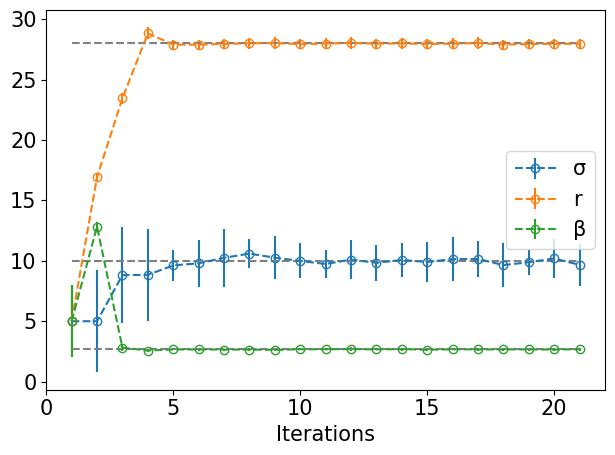

┌ Info: Initialize the 3-parameter Lorenz63 inverse problem
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Chaotic/Lorenz63.jl:217
┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483


In [4]:
Tobs = 20.0
Tspinup = 30.0

Δt = 0.01
N_θ = 3
x0 = [-8.67139571762; 4.98065219709; 25]
θ_ref = [10.0 ;28.0;8.0/3.0]
lorenz63_param = Setup_Param(N_θ, Tobs, Tspinup, Δt, x0, θ_ref)

T = Tspinup + 10.0*Tobs
y, Σ_η = data_gen(T, Tobs, Tspinup, f_mean_xi_xisq, Δt, θ_ref)

θ0_mean = fill(5.0, N_θ) 
θθ0_cov = Array(Diagonal(fill(1.0^2.0, N_θ)))
N_iter = 20
α_reg = 1.0
update_freq = 0
γ = 2.0

ukiobj = UKI_Run(lorenz63_param, forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, y, Σ_η, γ, α_reg, update_freq, N_iter)
θ_ref_nemas  = ["σ", "r", "β"]
plot_param_iter(ukiobj, θ_ref, θ_ref_nemas)
